## Plot Diff

This uses a labelled directory of frames (not used for training) to compare a model's predictions with the ground truth. This is plotted to make an easy way to see how extreme the differences in prediction/ground truth are.

In [107]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

## Preprocessing Functions

The only difference between airspeed/vertical speed/attitude implementation is the function for converting the normalized prediction values back into their respective units. This could probably be refactored to have less duplication.

In [186]:
model = tf.keras.models.load_model('../../models/regenerated_vertical_speed_model_20_epoch.h5')

def preprocess_image(image_path, bw = False):
    image = cv2.imread(image_path)

    # If enabled, remove color channel
    if(bw):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def predict_airspeed(image_path):
    preprocessed_image = preprocess_image(image_path)

    predictions = model.predict(preprocessed_image)

    predicted_speed = np.argmax(predictions, axis=1)

    return predicted_speed[0] * 10

def predict_vertical_speed(image_path, bw = False):
    preprocessed_image = preprocess_image(image_path, bw)

    predictions = model.predict(preprocessed_image)

    predicted_speed = np.argmax(predictions, axis=1)

    return (predicted_speed[0] * .25) - 6

def predict_attitude(image_path):
    preprocessed_image = preprocess_image(image_path)

    predictions = model.predict(preprocessed_image)

    predicted_speed = np.argmax(predictions, axis=1)

    return (predicted_speed[0] * .5) - 9.5

## Mode Select

Lots of specific labels for each instrument. Made them into a config so that you don't have to remember to change them.

In [187]:
modes = {
    'AIRSPEED': {
        'predict_function': predict_airspeed,
        'ground_truth_column_label': 'airspeed',
        'ground_truth_plot_label': 'Actual Airspeed',
        'predicted_plot_label': 'Predicted Airspeed',
        'plot_ylabel': 'Airspeed (knots)',
        'plot_title': 'Actual vs. Predicted Airspeed',
        'diff_plot_title': 'Difference Between Actual vs. Predicted Airspeed',
        'diff_plot_min_y': -500,
        'diff_plot_max_y': 500,
        'accuracy_threshold': 10
    },
    'VERTICAL_SPEED': {
        'predict_function': predict_vertical_speed,
        'ground_truth_column_label': 'airspeed',
        'ground_truth_plot_label': 'Actual Vertical Speed',
        'predicted_plot_label': 'Predicted Vertical Speed',
        'plot_ylabel': 'Vertical Speed (1000 feet / second)',
        'plot_title': 'Actual vs. Predicted Vertical Speed',
        'diff_plot_title': 'Difference Between Actual vs. Predicted Vertical Speed',
        'diff_plot_min_y': -12,
        'diff_plot_max_y': 12,
        'accuracy_threshold': 0.25
    },
    'ATTITUDE': {
        'predict_function': predict_attitude,
        'ground_truth_column_label': 'attitude',
        'ground_truth_plot_label': 'Actual Attitude',
        'predicted_plot_label': 'Predicted Attitude',
        'plot_ylabel': 'Attitude (10s of degrees)',
        'plot_title': 'Actual vs. Predicted Attitude',
        'diff_plot_title': 'Difference Between Actual vs. Predicted Attitude',
        'diff_plot_min_y': -10,
        'diff_plot_max_y': 10,
        'accuracy_threshold': 0.5
    }
}

mode = modes['VERTICAL_SPEED']

## Run Predictions

This records the model's prediction for each frame in the provided image directory. We can then compare this to the actual labelled data to get statistics. 

TODO: Rather than generating this every time, it would be nice to cache this data in case plots need to be regenerated at a later time.

In [188]:
image_directory = '../../media/night_fixed_A10C_validation_VS/'
csv_file = '../../image_labels/vertical_speed_labels/night_vertical_speed_validation_labels.csv'

df = pd.read_csv(csv_file)

def apply_prediction(row):
    image_path = row['image_path']

    result = mode['predict_function'](image_directory + "/" + image_path)
    return result

df['predicted_value'] = df.apply(apply_prediction, axis=1)

1/1 [==============================] - 0s 10ms/step


## Plot Ground Truth and Prediction over frames

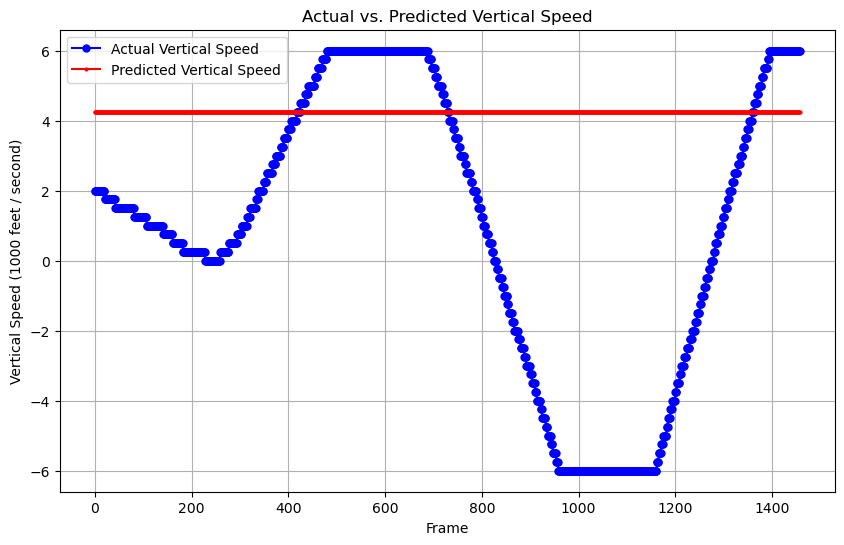

In [189]:
# Create a line plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot actual airspeed as a blue line
plt.plot(df[mode['ground_truth_column_label']], marker='o', linestyle='-', markersize=5, color='blue', label=mode['ground_truth_plot_label'])

# Plot predicted airspeed as a red line
plt.plot(df['predicted_value'], marker='o', markersize=2, linestyle='-', color='red', label=mode['predicted_plot_label'])

# Labeling and titles
plt.xlabel('Frame')
plt.ylabel(mode['plot_ylabel'])
plt.title(mode['plot_title'])
plt.legend()
plt.grid(True)

# Show plot

# plt.savefig('Airspeed_3_Epoch_Night_2.png', dpi=300, bbox_inches='tight')

plt.show()

## Plot difference between predictions and ground truth

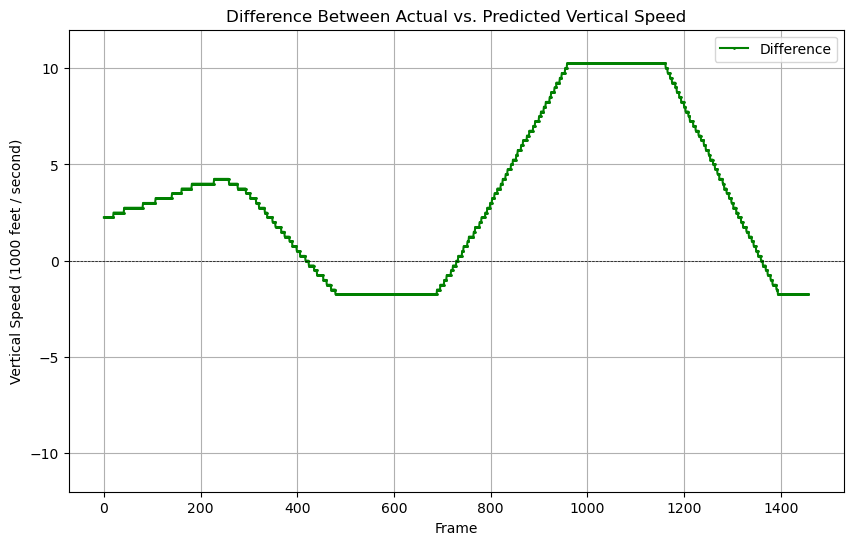

In [190]:
# Calculate the difference between predicted and actual airspeed
df['difference'] = df['predicted_value'] - df[mode['ground_truth_column_label']]

# Create a line plot for the difference
plt.figure(figsize=(10, 6))

# Plot the difference between predicted and actual airspeed
plt.plot(df['difference'], marker='o', linestyle='-', color='green', label='Difference', markersize=1)

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Labeling and titles
plt.xlabel('Frame')
plt.ylabel(mode['plot_ylabel'])
plt.ylim(mode['diff_plot_min_y'], mode['diff_plot_max_y'])

title_suffix = ''

plt.title(mode['diff_plot_title'] + title_suffix)
plt.legend()
plt.grid(True)

# Show plot
# plt.savefig('Airspeed_3_Epoch_Night_Diff_2.png', dpi=300, bbox_inches='tight')

plt.show()

## Generate Statistics

In [191]:
accuracy = (df['difference'] == 0).mean() * 100
print("Accuracy:", accuracy)

threshold = mode['accuracy_threshold']
within_threshold = (abs(df['difference']) <= threshold).mean() * 100
print(f"Percentage within {threshold} threshold:", within_threshold)

mean_difference = df['difference'].mean()
print("Mean difference:", mean_difference)

mae = abs(df['difference']).mean()
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error (MSE)
mse = np.mean(df['difference'] ** 2)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Median Absolute Error
median_absolute_error = np.median(np.abs(df['difference']))
print("Median Absolute Error:", median_absolute_error)

# Standard Deviation of the Differences
std_dev = np.std(df['difference'])
print("Standard Deviation of Differences:", std_dev)

Accuracy: 1.02880658436214
Percentage within 0.25 threshold: 4.38957475994513
Mean difference: 3.334533607681756
Mean Absolute Error (MAE): 4.142832647462277
Mean Squared Error (MSE): 27.935485253772292
Root Mean Squared Error (RMSE): 5.285403036077031
Median Absolute Error: 3.0
Standard Deviation of Differences: 4.100776862133947
